# Image Stitching

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [28]:
# Common variables

test_img = "train_images/Set1/1.jpg"
test_img2 = "train_images/Set1/2.jpg"

#### Corner Detection

In [29]:
# Compute likelihood of each pixel being a corner
def detect_corner(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  corner_scores = cv2.cornerHarris(gray_img, 2, 3, 0.04)
  return corner_scores

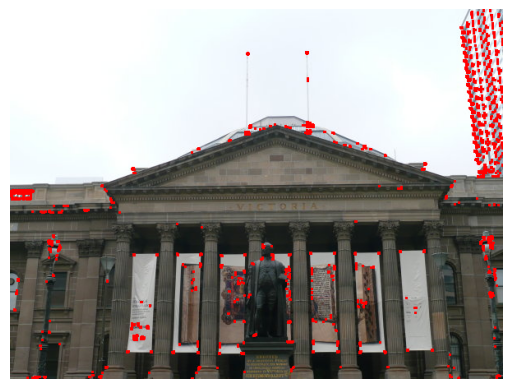

In [30]:
# Display image with potential corners marked

# Read an image
img = cv2.imread(test_img)

# Mark image with red dots at each potential corner
corner_scores = detect_corner(img)
corner_scores = cv2.dilate(corner_scores, None)
img[corner_scores > 0.01 * corner_scores.max()] = [0, 0, 255]

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### True Corner Detection with Adaptive Non-Maximal Suppression (ANMS)

In [31]:
# Calculate euclidean distance between points
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Calculate best point to represent a corner
def ANMS(cmap, num_best):
    corner_scores_flat = cmap.flatten()
    idx_1d = corner_scores_flat.argsort()[-num_best * 4:]
    x_idx, y_idx = np.unravel_index(idx_1d, corner_scores.shape)

    local_maxima_idx = []
    for x,y in zip(x_idx,y_idx):
        local_maxima_idx.append([x,y])

    r_i = [sys.maxsize] * len(local_maxima_idx)

    for i in range(len(local_maxima_idx)):
        for j in range(len(local_maxima_idx)):
            if i == j:
                continue
            point1 = local_maxima_idx[i]
            point2 = local_maxima_idx[j]

            dist = sys.maxsize

            if corner_scores[point1[0]][point1[1]] > corner_scores[point2[0]][point2[1]]:
                dist = euclidean_distance(point1, point2)
            if dist < r_i[i]:
                r_i[i] = dist

    for i in range(len(r_i)):
        if r_i[i] == sys.maxsize:
            r_i[i] = 0
    
    to_return = []
    ind = np.argpartition(r_i, -num_best)[-num_best:]
    for index in ind:
        to_return.append(local_maxima_idx[index])

    for lst in to_return:
        tmp = lst[0]
        lst[0] = lst[1]
        lst[1] = tmp

    return to_return

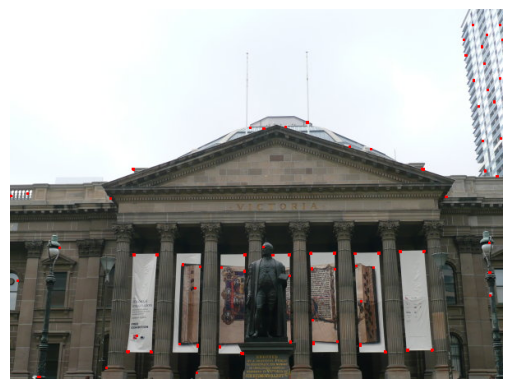

In [32]:
# Display image with corners marked

# Read image
img = cv2.imread(test_img)

# AMNS to calculate true corner points
corners = ANMS(detect_corner(img), 150)

# Binary image with marked corners
zeros = np.zeros_like(img)
for corner in corners:
    zeros[corner[1], corner[0]] = 1
dilated_arr = cv2.dilate(zeros, None)

# Mark corner with red dot
for i in range(zeros.shape[0]):
    for j in range(zeros.shape[1]):
        if np.any(dilated_arr[i][j]):
            img[i][j] = [0,0,255]

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### Encode Information About Corners: Feature Descriptors

In [33]:
# Calculate feature vectors (descriptors)
def feature_descript(gray_img, corners):
  feat_vec = []
  feat_loc = []

  for point in corners:
    x,y = int(point[0]), int(point[1])

    if x < 20 or x >= gray_img.shape[1] - 20 or y < 20 or y >= gray_img.shape[0] - 20: #Out of bounds
      continue

    patch = gray_img[y - 20: y + 20, x - 20: x + 20]
    blurred_patch = cv2.GaussianBlur(patch, (0, 0), sigmaX=2)
    subsample_patch = cv2.resize(blurred_patch, (8, 8))
    feature_vector = subsample_patch.reshape(64, 1)
    mean = np.mean(feature_vector)
    std = np.std(feature_vector)
    feature_vector = (feature_vector - mean) / std
    feat_vec.append(feature_vector)
    feat_loc.append(cv2.KeyPoint(x, y, 1))

  return feat_vec, feat_loc

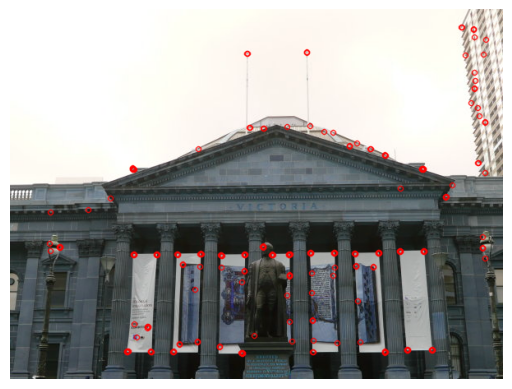

In [34]:
# Display image with feature descriptors

# Read image
img = cv2.imread(test_img)

# Grayscale image
g1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Get true corners
corners = ANMS(detect_corner(img), 250)

# Encode feature descriptors
feat_vecs1, feat_locs1 = feature_descript(g1, corners)

# Mark image
cv2.drawKeypoints(img, feat_locs1, img, (255,0,0), None)

# Display image
plt.imshow(img)
plt.axis("off")
plt.show()

#### Feature Matching

In [35]:
# Calculate sum of square distances
def square_dist(vec1, vec2):
    return np.sum((vec1-vec2)**2)

# Feature matching using corners
def feature_match(corner1, corner2, feat_locs1, feat_locs2):
    toReturn = [[], [], []]
    img1points = []
    img2points = []
    dpoints = []

    for i in range(len(feat_locs1)):
        feat_vec1 = corner1[i]

        best_match = sys.maxsize
        second_match = sys.maxsize

        best_idx = None
        second_idx = None
        for j in range(len(feat_locs2)):
            feat_vec2 = corner2[j]

            ssd = square_dist(feat_vec1, feat_vec2)

            if ssd < best_match:
                second_match = best_match
                best_match = ssd
                second_idx = best_idx
                best_idx = j

            elif ssd < second_match:
                second_match = ssd
                second_idx = j
            
            else:
                continue

        ratio = best_match / second_match
        if ratio < 10:
            img1points.append(feat_locs1[i])
            img2points.append(feat_locs2[best_idx])
            dpoints.append(cv2.DMatch(i, best_idx, 0))

    return img1points,img2points,dpoints

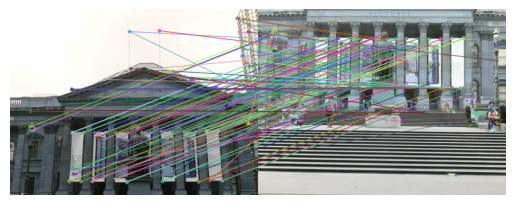

In [36]:
# Display 2 images with all potential features matched

# Read images
img1 = cv2.imread(test_img)
img2 = cv2.imread(test_img2)

# Grayscale images 
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Get corners for both images
corners1 = ANMS(detect_corner(img1), 250)
corners2 = ANMS(detect_corner(img2), 250)

# Encode feature descriptors for both images
feat_vecs1, feat_locs1 = feature_descript(g1, corners1)
feat_vecs2, feat_locs2 = feature_descript(g2, corners2)

# Match features from those images
img1p, img2p, points = feature_match(feat_vecs1, feat_vecs2, feat_locs1, feat_locs2)

# Draw lines between determined feature matches
matched = cv2.drawMatches(img1, feat_locs1, img2, feat_locs2, points, None)

# Display image
plt.imshow(matched)
plt.axis("off")
plt.show()

#### Outlier Rejection and Homography Estimation with RANSAC

In [37]:
def compute_ssd(point1, point2):
    return np.sum((point1 - point2) ** 2)

def apply_homography(point, H):
    p1_hom = np.array([point[0], point[1], 1], dtype=np.float32)
    transformed_point = np.dot(H, p1_hom)
    return transformed_point[:-1] / transformed_point[-1]

def dlt_rows(point1, point2):
    x, y = point1
    xp, yp = point2
    return np.array([
        [0, 0, 0, -x, -y, -1, yp*x, yp*y, yp],
        [x, y, 1, 0, 0, 0, -xp*x, -xp*y, -xp]
    ])

def compute_homography(src_points, dst_points):
    A = np.vstack([dlt_rows(p1, p2) for p1, p2 in zip(src_points, dst_points)])
    _, _, vt = np.linalg.svd(A)
    H = vt[-1].reshape(3, 3)
    return H, None

def RANSAC(match_kp1, match_kp2, N=1000, threshold=0.9, t=10):
    max_src_inliers, max_mapped_inliers, best_Dmatches = [], [], []
    num_matches = len(match_kp1)

    for _ in range(N):
        random_indices = random.sample(range(num_matches), 4)
        kp1, kp2 = [match_kp1[i] for i in random_indices], [match_kp2[i] for i in random_indices]

        H, _ = compute_homography(np.array(kp1), np.array(kp2))
        if H is None:
            continue

        src_inliers, mapped_inliers, Dmatches = [], [], []
        for i in range(num_matches):
            transformed_point = apply_homography(match_kp1[i], H)
            ssd = compute_ssd(np.array(match_kp2[i]), transformed_point)

            if ssd < t:
                src_inliers.append(match_kp1[i])
                mapped_inliers.append(match_kp2[i])
                Dmatches.append(cv2.DMatch(i, i, 0))

        if len(src_inliers) > len(max_src_inliers):
            max_src_inliers, max_mapped_inliers = src_inliers.copy(), mapped_inliers.copy()
            best_Dmatches = Dmatches.copy()

        if len(max_src_inliers) / num_matches > threshold:
            break

    result_H, _ = compute_homography(np.array(max_src_inliers), np.array(max_mapped_inliers))
    cPoints1 = [cv2.KeyPoint(a, b, 1) for a, b in match_kp1]
    cPoints2 = [cv2.KeyPoint(c, d, 1) for c, d in match_kp2]

    return result_H, cPoints1, cPoints2, best_Dmatches

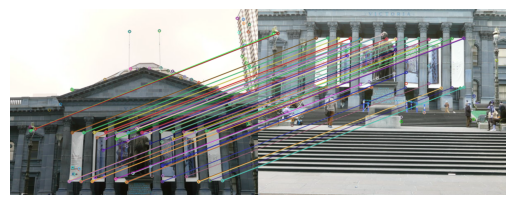

In [38]:
# Display true feature matches

kp1 = [feat_locs1[m.queryIdx].pt for m in points]
kp2 = [feat_locs2[m.trainIdx].pt for m in points]

H, c1, c2, matches = RANSAC(kp1,kp2)

# Draw feature matches between the images
matches_ransac = cv2.drawMatches(img1, c1, img2, c2, matches, None)

# Display image
plt.imshow(matches_ransac)
plt.axis("off")
plt.show()

#### Blend Images

In [39]:
def get_new_frame_size_and_matrix(H, sec_shape, base_shape):
    height, width = sec_shape
    initial_matrix = np.array([[0, width - 1, width - 1, 0],
                               [0, 0, height - 1, height - 1],
                               [1, 1, 1, 1]])
    final_matrix = np.dot(H, initial_matrix)
    x, y, c = final_matrix
    x /= c
    y /= c
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    new_width, new_height = max_x, max_y
    correction = [abs(min_x) if min_x < 0 else 0, abs(min_y) if min_y < 0 else 0]

    new_width = max(new_width, base_shape[1] + correction[0])
    new_height = max(new_height, base_shape[0] + correction[1])

    x += correction[0]
    y += correction[1]
    old_initial_points = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    new_final_points = np.float32(np.array([x, y]).T)

    H = cv2.getPerspectiveTransform(old_initial_points, new_final_points)

    return [new_height, new_width], correction, H

def warp_and_blend(img1, img2, H):
    img_1 = np.array(img1)
    img_2 = np.array(img2)
    new_frame, correction, matrix = get_new_frame_size_and_matrix(H, img_2.shape[:2], img_1.shape[:2])

    stitched_image = cv2.warpPerspective(img_2, matrix, (new_frame[1], new_frame[0]))
    stitched_image[correction[1]:correction[1]+img_1.shape[0], correction[0]:correction[0]+img_1.shape[1]] = img_1
    
    # Return stitched_image
    return stitched_image

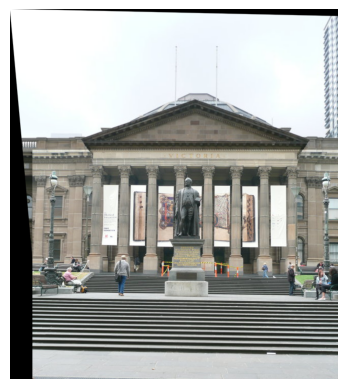

In [40]:
# Display stitched image

# Stitch images
stitched_image = warp_and_blend(img2, img1, H)

# Display image
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### Stitching Several Images

In [48]:
def detect_corner_new(img, scale=0.01):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corner_scores = cv2.cornerHarris(img_gray, 2, 3, 0.04)
    
    corner_candidates = np.argwhere(corner_scores > scale * corner_scores.max())

    corners = []
    for y, x in corner_candidates:
        local_max = corner_scores[y, x] == corner_scores[max(0, y-1):y+2, max(0, x-1):x+2].max()
        if local_max:
            corners.append((x, y))

    return np.array(corners)


def pano_imgs(img_list):
    panorama = img_list[0]

    for i in range(1, len(img_list)):
        corners1 = detect_corner_new(panorama)
        corners2 = detect_corner_new(img_list[i])
        # print((corners1, corners2))

        desc1, loc1 = feature_descript(cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY), corners1)
        desc2, loc2 = feature_descript(cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY), corners2)

        _, _, points = feature_match(desc1, desc2, loc1, loc2)

        kp1 = np.array([loc1[m.queryIdx].pt for m in points])
        kp2 = np.array([loc2[m.trainIdx].pt for m in points])

        H, _, _, _ = RANSAC(kp1, kp2)
        print(f"stitching image {i+1}")
        panorama = warp_and_blend(img_list[i], panorama, H)

done


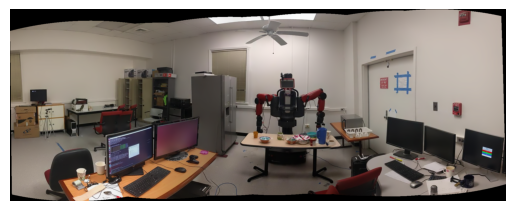

In [46]:
img1 = cv2.imread('train_images/Set3/1.jpg')
img2 = cv2.imread('train_images/Set3/2.jpg')
img3 = cv2.imread('train_images/Set3/3.jpg')
img4 = cv2.imread('train_images/Set3/4.jpg')
img5 = cv2.imread('train_images/Set3/5.jpg')
img6 = cv2.imread('train_images/Set3/6.jpg')
img7 = cv2.imread('train_images/Set3/7.jpg')
img8 = cv2.imread('train_images/Set3/8.jpg')

# our_code = pano_imgs([img1, img2, img3, img4, img5, img6, img7, img8])
stitchy=cv2.Stitcher.create() 
(dummy,output)=stitchy.stitch([img1, img2, img3, img4, img5, img6, img7, img8])

if dummy != cv2.STITCHER_OK:
    print("cv2 no worked")
else:
    print('done')

# plt.imshow(cv2.cvtColor(our_code, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [49]:
our_code = pano_imgs([img7, img8])
print(our_code)
plt.imshow(cv2.cvtColor(our_code, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

stitching image 2
None


error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [44]:
# Grayscale images 
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Get corners for both images
corners1 = ANMS(detect_corner(img1), 250)
corners2 = ANMS(detect_corner(img2), 250)

# Encode feature descriptors for both images
feat_vecs1, feat_locs1 = feature_descript(g1, corners1)
feat_vecs2, feat_locs2 = feature_descript(g2, corners2)

kp1 = [feat_locs1[m.queryIdx].pt for m in points]
kp2 = [feat_locs2[m.trainIdx].pt for m in points]

H, c1, c2, matches = RANSAC(kp1,kp2)

stitched_image = warp_and_blend(img2, img1, H)

# Display image
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

ValueError: index 428628 is out of bounds for array with size 270000